In [1]:
!pip install cplex

!pip install cplex

In [2]:
import cplex

In [9]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import matplotlib.pyplot as plt
%matplotlib inline


# Complete the following functions

# def strat_buy_and_hold_equally(x_init, cash_init, mu, Q, cur_prices):
    
#     total_cash= cur_prices@x_init+cash_init
    
#     x_optimal = np.array([ 1069,3255,1504, 95,2736,996,759,1064,457,308,1476,1810, 2793,1375,18726, 2431,2483,  162,1291,1235]);
#     trac_fee= abs(x_optimal-x_init) @cur_prices * 0.005
#     cash_optimal=total_cash-trac_fee- x_optimal @cur_prices 
    
#     return x_optimal, cash_optimal


def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal


def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    
    #xinit curr_positions
    #cash init, left cash, maybe 0 or positive
    # cur_prices  first trading day of each 2-month
    # get the price of each stock

    total_cash= cur_prices@x_init+cash_init
    money_allc=np.ones((20))*total_cash/20
    x_optimal=np.floor(money_allc/cur_prices)
    trac_fee= abs(x_optimal-x_init) @cur_prices * 0.005

    cash_optimal=total_cash-trac_fee- x_optimal @cur_prices 
        
    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    total_cash= np.dot(cur_prices, x_init)+cash_init
    
#     n=20
#     w1=cp.Variable(n)
#     prob1=cp.Problem(cp.Minimize(cp.quad_form(w1,Q)),[sum(w1)==1,w1>=0])
#     prob1.solve(solver=cp.CPLEX,verbose=False,cplex_params={"qpmethod":6})
#     w_minVar=w1.value
    
    n=20 
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    #A is for linear constrains
    A = []
    for k in range(n):
        A.append([[0],[1.0]])
    
    var_names = ["w_%s" % i for i in range(1,n+1)]
    
    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A,names=var_names)
    ## above all linear constrain and variable contrains

    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat) 
    
    alg = cpx.parameters.lpmethod.values
#     print("Setting solution algorithm = ", alg.concurrent)
    cpx.parameters.qpmethod.set(alg.concurrent)
    
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    w_minVar = cpx.solution.get_values()
    w_minVar=np.array(w_minVar)
 
    # new position
    x_optimal= np.floor(w_minVar*total_cash/cur_prices)

    trac_fee=abs(x_optimal-x_init)@cur_prices  *0.005

    cash_optimal=total_cash-trac_fee-x_optimal@cur_prices
    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    total_cash= np.dot(cur_prices, x_init)+cash_init
    
    n=21
    r_rf=0.025
    daily_r_rf=0.025/252
    u_rf=mu-daily_r_rf 
    u_rf_add=np.append(u_rf,0)
    Q=np.append(Q,np.zeros((20,1)),axis=1)
    Q=np.vstack([Q,np.zeros((21))])
    
#     y=cp.Variable(n)
#     prob=cp.Problem(cp.Minimize(cp.quad_form(y,Q)),[u_rf_add@y==1,sum(y[0:20])==y[20],y>=0])
#     prob.solve(solver=cp.CPLEX,verbose=False,cplex_params={'qpmethod':6})   
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [cplex.infinity] * n

    #A is for linear constrains
    A = []
    for k in range(n):
        if k==20:
            A.append([[0,1],[u_rf_add[k],-1]])
        else:
            A.append([[0,1],[u_rf_add[k],1.0]])
   
    
    var_names = ["y_%s" % i for i in range(1,n+1)]
    
    cpx.linear_constraints.add(rhs=[1.0,0.0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A,names=var_names)
    ## above all linear constrain and variable contrains    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
   
    alg = cpx.parameters.lpmethod.values
#     print("Setting solution algorithm = ", alg.concurrent)
    cpx.parameters.qpmethod.set(alg.concurrent)
    
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)

    cpx.solve()
    y_minVar = cpx.solution.get_values()
    y_minVar=np.array(y_minVar)
   
    w_minVar=y_minVar[0:20]/y_minVar[20]
    
    x_optimal= np.floor(w_minVar*total_cash/cur_prices)
    
    trac_fee=abs(x_optimal-x_init)@cur_prices  *0.005

    cash_optimal=total_cash-trac_fee-x_optimal@cur_prices
    
    return x_optimal, cash_optimal

def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):

    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal



def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):

    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal



def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal




    
    


# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe,strat_buy_and_hold_equally,strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(N_strat):

          # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

          # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

          # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
          # Check that cash account is >= 0
          # Check that we can buy new portfolio subject to transaction costs

          ###################### Insert your code here ############################
        if cash[strategy][period-1] < 0:

            total_cash=np.dot(cur_prices, curr_positions)+curr_cash

            ratio = x[strategy][period-1] / (sum(x[strategy][period-1]))
            cash_balance = abs(cash[strategy][period-1])* ratio
            position_balance = np.ceil(cash_balance / cur_prices)

            x[strategy][period-1] = x[strategy][period-1] - position_balance
            transaction = np.dot(cur_prices , abs(x[strategy][period-1] - curr_positions) )* 0.005
            cash[strategy][period-1] = total_cash - np.dot(cur_prices , x[strategy][period-1]) - transaction


        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))


    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################


Initial portfolio value = $ 1000002.12


Period 1: start date 1/2/2015, end date 2/27/2015
Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
Strategy "Equally Weighted Portfolio", value begin = $ 992880.88, value end = $ 1020038.79
Strategy "Mininum Variance Portfolio", value begin = $ 991454.43, value end = $ 1016159.03
Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990052.34, value end = $ 1007863.43
Strategy "Equal Risk Contributions Portfolio", value begin = $ 992880.88, value end = $ 1020038.79
Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1000002.12, value end = $ 1043785.08
Strategy "Robust Optimization Portfolio", value begin = $ 1000002.12, value end = $ 1043785.08

Period 2: start date 3/2/2015, end date 4/30/2015
Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
Strategy "Equally Weighted Portfolio", value begin = $ 1030724.21, value end = $ 1011178.46
Strategy "Mininum Variance P

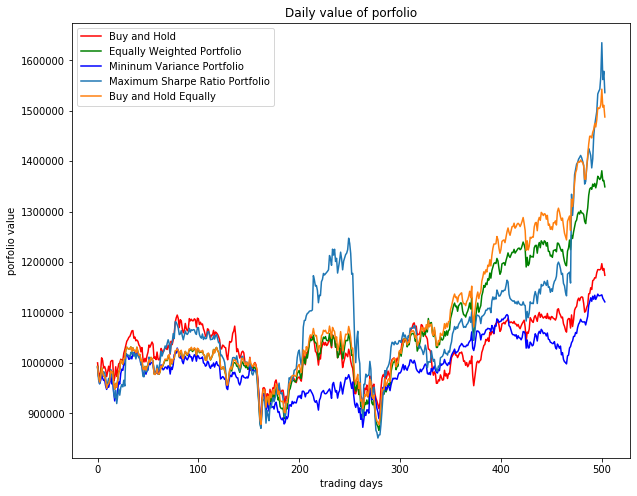

In [10]:
plt.figure(figsize=(10,8))
plt.plot(portf_value[0], color="r",label="Buy and Hold")
plt.plot(portf_value[1], color="g",label="Equally Weighted Portfolio")
plt.plot(portf_value[2], color="b",label="Mininum Variance Portfolio")
plt.plot(portf_value[3],label="Maximum Sharpe Ratio Portfolio")
plt.plot(portf_value[4],label="Buy and Hold Equally")

plt.legend(loc="best")
plt.title("Daily value of porfolio")
plt.ylabel("porfolio value")
plt.xlabel("trading days")

plt.show()

In [11]:
stock_name=df.columns[1:,]

In [12]:
#Mininum Variance Portfolio

Text(0.5, 0, 'trading period')

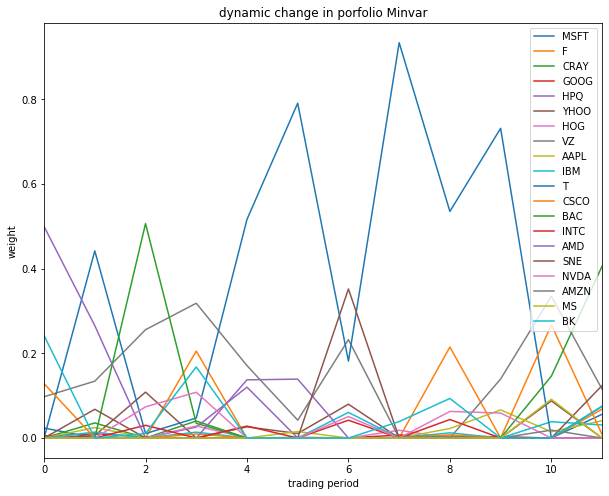

In [13]:
stock_name=df.columns[1:,]
w_min_var=[]
for period in range(1,N_periods+1):
    w_min_var.append(x[2, period-1]/sum(x[2, period-1]))
b=np.array(w_min_var)
df_stockweight=pd.DataFrame(b,columns=stock_name)
df_stockweight.plot(figsize=(10,8))
plt.legend(loc="upper right")


plt.title("dynamic change in porfolio Minvar")
plt.ylabel("weight")
plt.xlabel("trading period")

In [ ]:
#max sharpe ratio Portfolio
w_maxsharpe=[]
for period in range(1,N_periods+1):
    w_maxsharpe.append(x[3, period-1]/sum(x[3, period-1]))
a=np.array(w_maxsharpe)
df_stockweight=pd.DataFrame(a,columns=stock_name)
df_stockweight.plot(figsize=(10,8))
plt.legend(loc="upper right")


plt.title("dynamic change in porfolio Maxsharpe")
plt.ylabel("weight")
plt.xlabel("trading period")

In [ ]:
##select “1/n” portfolio at the beginning of period 1 and hold it till the end of period 12
# from the above test, we already know the max sharpe ratio is the best 



# we set n as 4, which means we keep 1/4 porfolio doesn't change
n=3



mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])
hold_positions=np.floor(init_positions*(1/n))
init_positions=init_positions-hold_positions

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# here, we set to keep 1/n porfolio doesn't change, and then we modify the remaining porfolio as the 

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]


    # Execute portfolio selection strategies
    for strategy  in range(N_strat):

          # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

          # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

          # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
          # Check that cash account is >= 0
          # Check that we can buy new portfolio subject to transaction costs

          ###################### Insert your code here ############################
        if cash[strategy][period-1] < 0:

            total_cash=np.dot(cur_prices, curr_positions)+curr_cash

            ratio = x[strategy][period-1] / sum(x[strategy][period-1])
            cash_balance = abs(cash[strategy][period-1])* ratio
            position_balance = np.ceil(cash_balance / cur_prices)

            x[strategy][period-1] = x[strategy][period-1] - position_balance
            transaction = np.dot(cur_prices , abs(x[strategy][period-1] - curr_positions) )* 0.005
            cash[strategy][period-1] = total_cash - np.dot(cur_prices , x[strategy][period-1]) - transaction


        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], (x[strategy, period-1]+hold_positions)) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))


    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)